
**Table of Contents**
 
1. [RNAseq](#RNAseq)     <br>
    * [1.1 Trim](#RNAseq_trim)<br>
    * [1.2 Gene expression](#RNAseq_exp)<br>
    * [1.3 Fusion](#RNAseq_fusion)<br>
    * [1.4 RNAseQC](#RNAseq_rnaseqc)<br>
2. [DNAseq](#DNAseq) <br>
    * [2.1 Generate bam](#DNAseq_bam)<br>
        * [2.1.1 Trim](#DNAseq_trim)<br>
        * [2.1.2 GATK best practice](#DNAseq_gatk)<br>
    * [2.2 Mutation calling](#DNAseq_snv)<br>
        * [2.2.1 Strelka](#DNAseq_strelka)<br>
        * [2.2.2 Varscan](#DNAseq_varscan)<br>
        * [2.2.3 Mutect](#DNAseq_mutect)<br>
        * [2.2.4 Pindel](#DNAseq_pindel)<br>
    * [2.3 Copy number variations](#DNAseq_cnv)<br>
        * [2.3.1 CNVkit](#DNAseq_cnvkit)<br>
        * [2.3.2 Sequenza](#DNAseq_seqz)<br>
        * [2.3.3 PureCN](#DNAseq_purecn)<br>

## <a class  = "anchor" id="RNAseq"></a>  RNAseq 
---

- input: rna_fq.ls
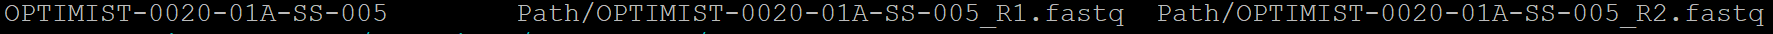
    
- script: generate_sh.pl
- generate shell file:
`perl /home/hef/2.project/2.OPTIMIST/2.RNA/generate_sh.pl rna_fq.ls`


### <a id="RNAseq_trim"></a> Trim

- input: fastq
- output: trimmed fastq

trim_galore:


`trim_galore --phred33 --fastqc --length 50 -q 20 --dont_gzip -o /project/gccri/OPTIMIST/analysis/RNA/1.trim/trimmed_fq --paired /project/gccri/OPTIMIST/fastq/RNA/Sample_OPTIMIST-0020-01A-SS-005/OPTIMIST-0020-01A-SS-005_R1.fastq /project/gccri/OPTIMIST/fastq/RNA/Sample_OPTIMIST-0020-01A-SS-005/OPTIMIST-0020-01A-SS-005_R2.fastq
`

link and rename fastq file:

`ln -s /project/gccri/OPTIMIST/analysis/RNA/1.trim/trimmed_fq/OPTIMIST-0020-01A-SS-005_R1_val_1.fq /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R1.fq 
ln -s /project/gccri/OPTIMIST/analysis/RNA/1.trim/trimmed_fq/OPTIMIST-0020-01A-SS-005_R2_val_2.fq /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R2.fq
`

### <a id="RNAseq_exp"></a>Gene expression

- input: fastq/bam
- output: gene expression matrix
- other files: 
    gencode.v22.all_transcripts.fa.idx;
    gencode.v22.annotation.gff3;

kallisto: 

`
kallisto quant -i /home/hef/Data/hg38/optimist_ref/gencodev22/gencode.v22.all_transcripts.fa.idx -o /project/gccri/OPTIMIST/analysis/RNA/2.exp/1.kallisto/OPTIMIST-0020-01A-SS-005 -t 8 --plaintext /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R1.fq /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R2.fq
`

RSEM:
- run rsem (PRADA2):

`
source /home/hef/Tools/miniconda3/etc/profile.d/conda.sh;conda activate py2
python /home/hef/Tools/PRADA2-master/prada2.py --read1 /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R1.fq --read2 /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R2.fq --outdir /project/gccri/OPTIMIST/analysis/RNA/3.fusion/2.PRADA --rsem
conda deactivate`

`ln -s /project/gccri/OPTIMIST/analysis/RNA/3.fusion/2.PRADA/OPTIMIST-0020-01A-SS-005/rsem_results/rsem.genes.results /project/gccri/OPTIMIST/analysis/RNA/2.exp/2.rsem/OPTIMIST-0020-01A-SS-005.genes.results
ln -s /project/gccri/OPTIMIST/analysis/RNA/3.fusion/2.PRADA/OPTIMIST-0020-01A-SS-005/rsem_results/rsem.isoforms.results /project/gccri/OPTIMIST/analysis/RNA/2.exp/2.rsem/OPTIMIST-0020-01A-SS-005.isoforms.results
`

HTseq:
- Sort:

`samtools sort -m 2G -@ 8 -o /project/gccri/OPTIMIST/analysis/RNA/2.exp/3.htseq/OPTIMIST-0020-01A-SS-005.sorted.bam /project/gccri/OPTIMIST/analysis/RNA/3.fusion/1.star_fusion/OPTIMIST-0020-01A-SS-005/Aligned.out.bam
samtools index /project/gccri/OPTIMIST/analysis/RNA/2.exp/3.htseq/OPTIMIST-0020-01A-SS-005.sorted.bam`
- htseq:

`htseq-count -s no -f bam -r pos -n 8 -t exon -i ID -m union --nonunique all /project/gccri/OPTIMIST/analysis/RNA/2.exp/3.htseq/OPTIMIST-0020-01A-SS-005.sorted.bam /home/hef/Data/hg38/optimist_ref/gencodev22/gencode.v22.annotation.gff3 --additional-attr=gene_id --additional-attr=gene_name --additional-attr=transcript_id --additional-attr=exon_number > /project/gccri/OPTIMIST/analysis/RNA/2.exp/3.htseq/OPTIMIST-0020-01A-SS-005.htseq.txt`

 


### <a id="RNAseq_fusion"></a> Fusion

- input: fastq
- output: gene fusions
- other files: 
    - STAR-Fusion: GRCh38_gencode_v22.star-fusion.v1.10

STAR-Fusion:

`
/home/hef/Tools/STAR-Fusion-v1.10.0/STAR-Fusion --genome_lib_dir /home/hef/Data/hg38/optimist_ref/GRCh38_gencode_v22.star-fusion.v1.10 --left_fq /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R1.fq --right_fq /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R2.fq --FusionInspector validate --examine_coding_effect --CPU 8 --output_dir /project/gccri/OPTIMIST/analysis/RNA/3.fusion/1.star_fusion/OPTIMIST-0020-01A-SS-005
`

PRADA2: 

`
source /home/hef/Tools/miniconda3/etc/profile.d/conda.sh
conda activate prada
python /home/hef/Tools/PRADA2-master/prada2.py --read1 /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R1.fq --read2 /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R2.fq --outdir /project/gccri/OPTIMIST/analysis/RNA/3.fusion/2.PRADA
python /home/hef/Tools/PRADA2-master/prada2.py --read1 /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R1.fq --read2 /project/gccri/OPTIMIST/analysis/RNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-005.R2.fq --outdir /project/gccri/OPTIMIST/analysis/RNA/3.fusion/2.PRADA --fusion
conda deactivate
`


### <a id="RNAseq_rnaseqc"></a>  RNASeQC

- input: bam
- output: metrics.tsv
- other files: gencode.v22.genes.gtf

`rnaseqc /home/hef/Data/hg38/gencode.v22.genes.gtf /project/gccri/OPTIMIST/analysis/RNA/2.exp/3.htseq/OPTIMIST-0020-01A-SS-005.sorted.bam --coverage /project/gccri/OPTIMIST/analysis/RNA/4.rnaseqc/OPTIMIST-0020-01A-SS-005`

## <a id="DNAseq"></a>  DNAseq
---

- input: 
    - dna_fq.ls
    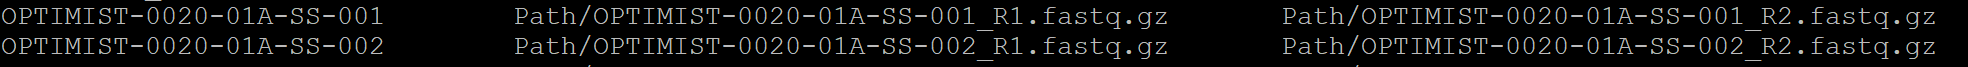
    - paired.ls:
    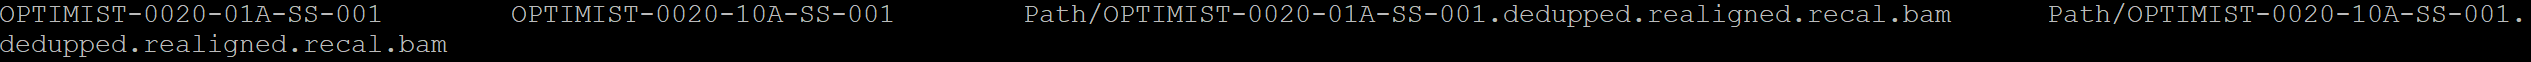
- script: 1.generate_bam.pl  2.generate_snv.pl  3.generate_cnv.pl
- generate shell file:

`perl 1.generate_bam.pl dna_fq.ls
perl 2.generate_snv.pl paired.ls
perl 3.generate_cnv.pl paired.ls`

### <a id="DNAseq_bam"></a>Generate bam

#### <a id="DNAseq_trim"></a>Trim

`trim_galore --phred33 --fastqc --length 50 -q 20 -o /project/gccri/OPTIMIST/analysis/DNA/1.trim/trimmed_fq --paired /project/gccri/OPTIMIST/fastq/DNA/OPTIMIST-0020-01A-SS-001_R1.fastq.gz /project/gccri/OPTIMIST/fastq/DNA/OPTIMIST-0020-01A-SS-001_R2.fastq.gz
ln -s /project/gccri/OPTIMIST/analysis/DNA/1.trim/trimmed_fq/OPTIMIST-0020-01A-SS-001_R1_val_1.fq.gz /project/gccri/OPTIMIST/analysis/DNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-001.R1.fq.gz
ln -s /project/gccri/OPTIMIST/analysis/DNA/1.trim/trimmed_fq/OPTIMIST-0020-01A-SS-001_R2_val_2.fq.gz /project/gccri/OPTIMIST/analysis/DNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-001.R2.fq.gz`

#### <a id="DNAseq_gatk"></a>GATK best practice

- input: fastq
- output: bam
- other files:
    - Homo_sapiens_assembly38.fasta
    - Homo_sapiens_assembly38.dbsnp138.vcf
    - 1000G_phase1.snps.high_confidence.hg38.vcf
    - Mills_and_1000G_gold_standard.indels.hg38.vcf
    - Homo_sapiens_assembly38.known_indels.vcf

Generate bam:

`
bwa mem -t 8 -M -R "@RG\tID:OPTIMIST-0020-01A-SS-001\tPL:illumina\tLB:OPTIMIST-0020-01A-SS-001\tPU:OPTIMIST-0020-01A-SS-001\tSM:OPTIMIST-0020-01A-SS-001" /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta /project/gccri/OPTIMIST/analysis/DNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-001.R1.fq.gz /project/gccri/OPTIMIST/analysis/DNA/1.trim/Final_fq/OPTIMIST-0020-01A-SS-001.R2.fq.gz|samtools view -Shb -o /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.bam -`

AddOrReplaceReadGroups:

`
java -Xmx16g -Djava.io.tmpdir=/home/hef/2.project/2.OPTIMIST/1.DNA/tmp -jar /home/hef/Tools/miniconda3/bin/picard.jar AddOrReplaceReadGroups I=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.bam O=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.added.sorted.bam SO=coordinate RGLB=OPTIMIST-0020-01A-SS-001 RGPL=illumina RGPU=OPTIMIST-0020-01A-SS-001 RGSM=OPTIMIST-0020-01A-SS-001
samtools flagstat /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.added.sorted.bam > /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.mapping.txt
`

MarkDuplicates:

`
java -Xmx16g -Djava.io.tmpdir=/home/hef/2.project/2.OPTIMIST/1.DNA/tmp -jar /home/hef/Tools/miniconda3/bin/picard.jar MarkDuplicates I=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.added.sorted.bam O=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.added.dedupped.bam VALIDATION_STRINGENCY=SILENT CREATE_INDEX=true M=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedup.metrics.txt
`

Realigner:

`
java -Xmx16g -Djava.io.tmpdir=/home/hef/2.project/2.OPTIMIST/1.DNA/tmp -jar /home/hef/Tools/gatk-4.2.3.0/GenomeAnalysisTK.jar -T RealignerTargetCreator -nt 8 -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -I /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.added.dedupped.bam -known /home/hef/Data/hg38/resources_broad_hg38_v0/Mills_and_1000G_gold_standard.indels.hg38.vcf -known /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.known_indels.vcf -o /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.intervals.list
java -Xmx16g -Djava.io.tmpdir=/home/hef/2.project/2.OPTIMIST/1.DNA/tmp -jar /home/hef/Tools/gatk-4.2.3.0/GenomeAnalysisTK.jar -T IndelRealigner -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -I /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.added.dedupped.bam -known /home/hef/Data/hg38/resources_broad_hg38_v0/Mills_and_1000G_gold_standard.indels.hg38.vcf -known /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.known_indels.vcf -targetIntervals /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.intervals.list  -o /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.bam
`

BaseRecalibrator:

`
java -Xmx16g -Djava.io.tmpdir=/home/hef/2.project/2.OPTIMIST/1.DNA/tmp -jar /home/hef/Tools/gatk-4.2.3.0/GenomeAnalysisTK.jar -T BaseRecalibrator -nct 8 -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -I /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.bam --knownSites /home/hef/Data/hg38/resources_broad_hg38_v0/1000G_phase1.snps.high_confidence.hg38.vcf --knownSites /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.dbsnp138.vcf --knownSites /home/hef/Data/hg38/resources_broad_hg38_v0/Mills_and_1000G_gold_standard.indels.hg38.vcf --knownSites /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.known_indels.vcf -o /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.data.table
java -Xmx16g -Djava.io.tmpdir=/home/hef/2.project/2.OPTIMIST/1.DNA/tmp -jar /home/hef/Tools/gatk-4.2.3.0/GenomeAnalysisTK.jar -T PrintReads -nct 8 -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -I /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.bam -BQSR /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.data.table -o /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.recal.bam
`

### <a id="DNAseq_snv"></a> Mutation calling

- input: recal.bam
- output: vcf
- otherfiles:
    - gatk4_mutect2_4136_pon.vcf.gz
    - af-only-gnomad.hg38.vcf.gz
    - wgs_calling_regions.hg38.interval_list
    - hg38.centromere_telomere.bed

#### <a id="DNAseq_strelka"></a>Strelka



runManta (for large in-frame indels):

`source /home/hef/Tools/miniconda3/etc/profile.d/conda.sh;conda activate py2
configManta.py --normalBam=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-10A-SS-001.dedupped.realigned.recal.bam --tumorBam=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.recal.bam --referenceFasta=/home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta  --runDir=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/manta
/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/manta/runWorkflow.py -j 4 -g 4 >>/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka_run.log 2>&1
`

run Strelka:

`
configureStrelkaSomaticWorkflow.py --normalBam=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-10A-SS-001.dedupped.realigned.recal.bam --tumorBam=/project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.recal.bam --referenceFasta=/home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta --callMemMb=2048  --runDir=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka --indelCandidates=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/manta/results/variants/candidateSmallIndels.vcf.gz >/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka_run.log 2>&1
/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/runWorkflow.py -m local -j 4 -g 4 >>/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka_run.log 2>&1
`

Generate vcf:

`
less /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/results/variants/somatic.snvs.vcf.gz|bcftools view -i 'FILTER="PASS"'>/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/strelka.snvs.vcf
less /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/results/variants/somatic.indels.vcf.gz|bcftools view -i 'FILTER="PASS"'>/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/strelka.indels.vcf
`

Merge:

`
picard MergeVcfs I=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/results/variants/somatic.snvs.vcf.gz I=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/results/variants/somatic.indels.vcf.gz O=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/somatic.merge.vcf
bcftools view -f PASS /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/somatic.merge.vcf >  /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/somatic.merge.filter.vcf
vcf-genotype-annotator /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/strelka/somatic.merge.filter.vcf TUMOR 0/1 -o /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.strelka.vcf
`

#### <a id="DNAseq_varscan"></a>Varscan

- varscan_bam.ls(example): 

` normal_bam  tumor_bam`
    

Run Varscan:

`samtools mpileup -q 1 -Q 13 -f /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -b /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan_bam.ls|varscan somatic - /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.out.som --mpileup 1 --output-vcf 1 --output-snp /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan_snp --output-indel /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan_indel > /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan_run.log 2>&1`

Generate somatic mutations:

`
varscan processSomatic /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan_indel.vcf
varscan processSomatic /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan_snp.vcf
varscan somaticFilter /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan_snp.Somatic.hc.vcf  --indel-file /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan_indel.Somatic.hc.vcf --output-file /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.snv.vcf
varscan somaticFilter /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan_indel.Somatic.hc.vcf --output-file /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.indel.vcf
`

Merge & filter:

`
bgzip /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.indel.vcf; tabix -p vcf /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.indel.vcf.gz
bgzip /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.snv.vcf; tabix -p vcf /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.snv.vcf.gz
bcftools concat -a /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.indel.vcf.gz /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.snv.vcf.gz > /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.merge.vcf
perl /home/hef/Tools/fpfilter.pl --vcf-file  /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/varscan.filtered.merge.vcf --bam-file /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.recal.bam  --sample TUMOR --reference /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta --output /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/OPTIMIST-0020-01A-SS-001.varscan.result.vcf
bcftools view -f PASS /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/varscan/OPTIMIST-0020-01A-SS-001.varscan.result.vcf > /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.varscan.vcf
`

#### <a id="DNAseq_mutect"></a>Mutect

Run Mutect:

`gatk Mutect2 -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -L /home/hef/Data/files_liding/mutect/wgs_calling_regions.hg38.interval_list -I /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.recal.bam -tumor OPTIMIST-0020-01A-SS-001 -I /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-10A-SS-001.dedupped.realigned.recal.bam -normal OPTIMIST-0020-10A-SS-001 --germline-resource /home/hef/Data/files_liding/mutect/af-only-gnomad.hg38.vcf.gz --panel-of-normals /home/hef/Data/files_liding/mutect/gatk4_mutect2_4136_pon.vcf.gz -O /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.raw.vcf > /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect_run.log 2>&1
`

Filter:

`
gatk FilterMutectCalls -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -V /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.raw.vcf -O /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.filter.vcf
gatk SelectVariants -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -V /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.filter.vcf -O /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.raw.snp.vcf --select-type-to-include SNP --select-type-to-include MNP;gatk SelectVariants -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -V /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.filter.vcf -O /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.raw.indel.vcf --select-type-to-include INDEL
less /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.raw.snp.vcf|bcftools view -i 'FILTER="PASS"'>/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.fil.snp.vcf
less /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.raw.indel.vcf|bcftools view -i 'FILTER="PASS"'>/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.fil.indel.vcf
`

Merge:

`
picard MergeVcfs I=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.fil.snp.vcf I=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/mutect/mutect.fil.indel.vcf O=/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.mutect.vcf
`

#### <a id="DNAseq_pindel"></a> Pindel

- pindel.config (example): bam - insert size - id
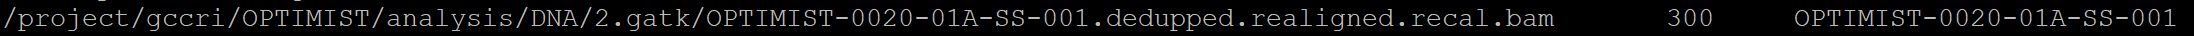

- pindel.filter.config (example):

`pindel.filter.variants_file = /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/all.header
pindel.filter.pindel2vcf = /home/hef/Tools/miniconda3/bin/pindel2vcf
pindel.filter.REF = /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta
pindel.filter.heterozyg_min_var_allele_freq = 0.2
pindel.filter.homozyg_min_var_allele_freq = 0.8
pindel.filter.mode = somatic
pindel.filter.apply_filter = true
pindel.filter.somatic.min_coverages_t = 10
pindel.filter.somatic.min_coverages_n = 3
pindel.filter.somatic.min_var_allele_freq = 0.10
pindel.filter.somatic.require_balanced_reads = true
pindel.filter.somatic.remove_complex_indels = true
pindel.filter.somatic.max_num_homopolymer_repeat_units = 6
pindel.filter.date=20221225`

Run Pindel:

`pindel -T 8 -f /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -i /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/pindel.config --exclude /home/hef/Data/hg38/hg38.centromere_telomere.bed -o /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/pindel_raw >/project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel_run.log 2>&1
cat /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/pindel*_D /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/pindel*_SI |grep ChrID > /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/all.header
`

Filter:

`
perl /home/hef/Tools/somaticwrapper-master/pindel_filter.v0.5.pl /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/pindel.filter.config
vt normalize /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/all.header.CvgVafStrand_pass.Homopolymer_pass.vcf -r /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -o /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/OPTIMIST-0020-01A-SS-001.indel.filter.output.norm.vcf -n
perl /home/hef/2.project/1.PDX/4.DNAseq_mutation/1.somatic/1.paired/add_pindel_flag.pl /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/OPTIMIST-0020-01A-SS-001.indel.filter.output.norm.vcf > /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/OPTIMIST-0020-01A-SS-001.indel.filter.output.norm.flag.vcf
vt normalize /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/all.header.CvgVafStrand_pass.Homopolymer_pass.vcf -r /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -o /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/OPTIMIST-0020-01A-SS-001.indel.filter.output.norm.vcf -n
perl /home/hef/2.project/1.PDX/4.DNAseq_mutation/1.somatic/1.paired/add_pindel_flag.pl /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/OPTIMIST-0020-01A-SS-001.indel.filter.output.norm.vcf > /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/OPTIMIST-0020-01A-SS-001.indel.filter.output.norm.flag.vcf
`

Generate vcf:

`bcftools view -f PASS /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/pindel/OPTIMIST-0020-01A-SS-001.indel.filter.output.norm.flag.vcf > /project/gccri/OPTIMIST/analysis/DNA/3.snv/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.pindel.vcf
`

### <a id="DNAseq_cnv"></a> Copy number variations

- input: bam
- output: seg file

#### <a id="DNAseq_cnvkit"></a> cnvkit

Link bam/bai files:
`ln -s /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.recal.bam /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.T.bam
ln -s /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.recal.bai /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.T.bam.bai
ln -s /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-10A-SS-001.dedupped.realigned.recal.bam /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.N.bam
ln -s /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-10A-SS-001.dedupped.realigned.recal.bai /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.N.bam.bai
`

Run cnvkit
 
`bash /home/hef/Tools/cnvkit_liding/src/cnvkit_wxs.tumorNormal.v2.sh -C /home/hef/Tools/cnvkit_liding/config/config.gencode_grch38.mgi.ini -p -1.1,-0.4,0.3,0.7 -S OPTIMIST-0020-01A-SS-001 -N /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.N.bam -T /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.T.bam -O /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit|sh`


#### <a id="DNAseq_seqz"></a>sequenza (for WES only)

- Rscript (example):
`
library(sequenza) <br>
data.file <- "/project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002/OPTIMIST-0020-01A-SS-002.seqz.gz" <br>
seqz <-sequenza.extract(data.file,verbose=FALSE) <br>
CP <- sequenza.fit(seqz)<br>
sequenza.results(sequenza.extract = seqz, cp.table = CP, sample.id = "OPTIMIST-0020-01A-SS-002", out.dir="/project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002")

`

Generate seqz file:

`
/home/hef/Tools/miniconda3/bin/sequenza-utils bam2seqz -n /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-10A-SS-002.dedupped.realigned.recal.bam -t /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-002.dedupped.realigned.recal.bam --fasta /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -gc /home/hef/Data/hg38/resources_broad_hg38_v0/hg38.gc50Base.wig.gz -o /project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002/OPTIMIST-0020-01A-SS-002.seqz.gz
less /project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002/OPTIMIST-0020-01A-SS-002.seqz.gz|grep -v "_random" |bgzip > /project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002/new.gz; mv /project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002/new.gz /project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002/OPTIMIST-0020-01A-SS-002.seqz.gz; tabix -f -s 1 -b 2 -e 2 -S 1 /project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002/OPTIMIST-0020-01A-SS-002.seqz.gz
`

Run sequenza:

`
Rscript /project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002.r > /project/gccri/OPTIMIST/analysis/DNA/4.cnv/seqz/OPTIMIST-0020-01A-SS-002.log 2>&1
`


#### <a id="DNAseq_purecn"></a>pureCN 

Convert cnvkit_cnr to seg: 

`cnvkit.py export seg /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.T.cns --enumerate-chroms -o /project/gccri/OPTIMIST/analysis/DNA/4.cnv/pureCN/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.seg
`

Run Mutect2 to call germline mutations:

`
gatk Mutect2 -R /home/hef/Data/hg38/resources_broad_hg38_v0/Homo_sapiens_assembly38.fasta -L /home/hef/Data/files_liding/mutect/wgs_calling_regions.hg38.interval_list -I /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-01A-SS-001.dedupped.realigned.recal.bam -tumor OPTIMIST-0020-01A-SS-001 -I /project/gccri/OPTIMIST/analysis/DNA/2.gatk/OPTIMIST-0020-10A-SS-001.dedupped.realigned.recal.bam -normal OPTIMIST-0020-10A-SS-001 --germline-resource /home/hef/Data/files_liding/mutect/af-only-gnomad.hg38.vcf.gz --panel-of-normals /home/hef/Data/files_liding/mutect/gatk4_mutect2_4136_pon.vcf.gz -XL /home/hef/Data/hg38/hg38.centromere_telomere.bed -O /project/gccri/OPTIMIST/analysis/DNA/4.cnv/pureCN/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.raw.vcf --genotype-germline-sites true --genotype-pon-sites true
`

Run pureCN:

`
Rscript /home/hef/Tools/miniconda3/lib/R/library/PureCN/extdata/PureCN.R --out /project/gccri/OPTIMIST/analysis/DNA/4.cnv/pureCN/OPTIMIST-0020-01A-SS-001 --sampleid OPTIMIST-0020-01A-SS-001 --tumor /project/gccri/OPTIMIST/analysis/DNA/4.cnv/cnvkit/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.T.cnr --seg-file /project/gccri/OPTIMIST/analysis/DNA/4.cnv/pureCN/OPTIMIST-0020-01A-SS-001/OPTIMIST-0020-01A-SS-001.seg --mapping-bias-file /project/gccri/CPRIT_PDX/hef_folder/5.CNV/pureCN/WES_mapping_bias.rds --vcf /project/gccri/OPTIMIST/analysis/DNA/4.cnv/pureCN/OPTIMIST-0020-01A-SS-002/OPTIMIST-0020-01A-SS-002.raw.vcf --snp-blacklist /project/gccri/CPRIT_PDX/hef_folder/5.CNV/pureCN/hg38_simpleRepeats.bed --genome hg38 --fun-segmentation none --force --post-optimize --seed 123 --sex ?
`